## Exercise 1 - Culinary History

First name: Brian
<br>
Last name: Schweigler
<br>
Matriculation number: 16-102-071

##### Q1: Consider the function plot_trend() used in the lectures. Discover the two ingredients that appear more frequently in the 20th century and in the beginning of the 19th century.


General imports and set-up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.feature_selection import chi2
import scipy


df = pd.read_csv("data/feeding-america.csv", index_col='date')
def plot_trend(column, df, line_color='grey', xlim=(1810, 1930)):
    slope, intercept, _, _, _ = scipy.stats.linregress(
    df.index, df[column].fillna(0).values)

    ax = df[column].plot(style='o', label=column)
    ax.plot(df.index, intercept + slope * df.index, '--',
    color=line_color, label='_nolegend_')
    ax.set_ylabel("fraction of recipes")
    ax.set_xlabel("year of publication")
    ax.set_xlim(xlim)

In the following, we will simply try to recreate some of the functions seen in the lecture.

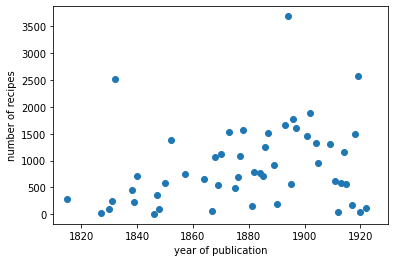

In [2]:
grouped = df.groupby('date')
recipe_counts = grouped.size()
recipe_counts.plot(style='o', xlim=(1810, 1930)) #<AxesSubplot:xlabel='date'> # plot the group size
plt.ylabel("number of recipes")
plt.xlabel("year of publication")
plt.show()

Next the grouping of ingredients with some different naming for clarity.

In [3]:
ingredients = df['ingredients'].str.split(';')
groups = ingredients.groupby(ingredients.keys())
ingredients_sum = groups.sum()
most_used_ingredients = ingredients_sum.max()
ingredients_per_annum = ingredients_sum.apply(pd.Series.value_counts)
ingredients_normalized = ingredients_per_annum.divide(recipe_counts, 0)

Going by the lecture, we can assume that both baking powder and tomato are the ones that see the sharpest increase in usage.

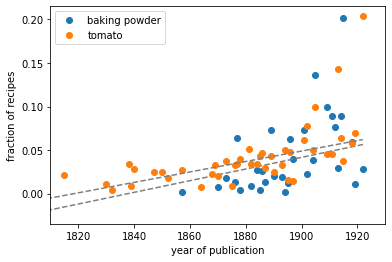

In [4]:
plot_trend('baking powder', ingredients_normalized)
plot_trend('tomato', ingredients_normalized)
plt.legend()
plt.show()

We could compare them to the three generally most used ones like water, currant jelly, and juice. (Gathered through most_used_ingredients)

Coincidentally, they remain quite constant in their usage.

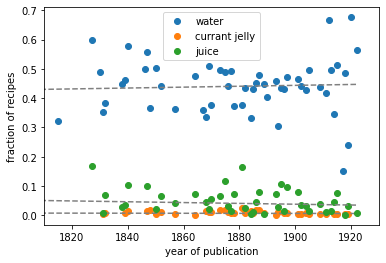

In [5]:
plot_trend('water', ingredients_normalized)
plot_trend('currant jelly', ingredients_normalized)
plot_trend('juice', ingredients_normalized)
plt.legend()
plt.show()

##### Q2: Can you compare the recipes appearing in books published between 1820-1840 with those from the period 1900–1920? Which are for you the main differences?


For this, we will simply aim to use the same chi2 statistic as used in the lecture, differentiating between the ranges.

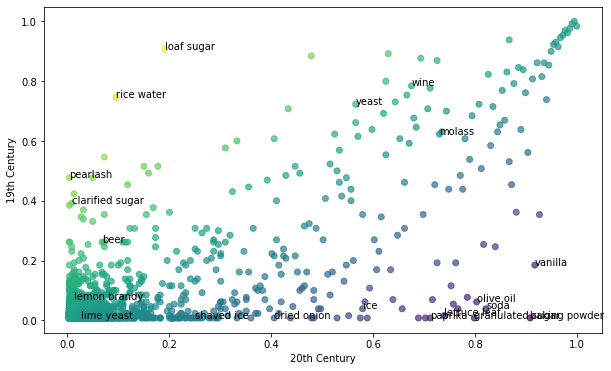

In [6]:
labels_early_19 = ['19th century' if 1819 < year < 1841 else 'Unused' for year in ingredients_normalized.index]
labels_early_20 = ['20th century' if 1899 < year < 1921 else 'Unused' for year in ingredients_normalized.index]

keyness, _ = chi2(ingredients_normalized.fillna(0), labels_early_19)
keyness_19 = pd.Series(keyness, index=ingredients_normalized.columns).sort_values(ascending=False)
keyness, _ = chi2(ingredients_normalized.fillna(0), labels_early_20)
keyness_20 = pd.Series(keyness, index=ingredients_normalized.columns).sort_values(ascending=False)

keyness_19.head(n=10)
keyness_20.head(n=10)

# Step 1: compute summed ingredient counts per year (in a matrix date x ingredients)
counts = df['ingredients'].str.split(';').groupby('date').sum().apply(pd.Series.value_counts).fillna(0)

# Step 2: construct two frequency rankings, one pre- and one post-war years

nineteenth_century=counts[np.logical_and(counts.index>1819, counts.index<1841)].sum().rank(method='dense', pct=True)
twentieth_century=counts[np.logical_and(counts.index>1899, counts.index<1921)] .sum().rank(method='dense', pct=True)

# Step 3: merge the 19th and 20th century dataframes resulting into two dataframes
rankings=pd.DataFrame({'19th Century': nineteenth_century, '20th Century': twentieth_century})

# Step 4: produce the plot
fig = plt.figure(figsize=(10, 6))
plt.xlabel("20th Century")
plt.ylabel("19th Century")
plt.scatter(rankings['20th Century'], rankings['19th Century'],
            c=rankings['19th Century']-rankings['20th Century'],
            alpha=0.7) # c = color

# Add annotations of the 10 most distinctive ingredients per century
for i, row in rankings.loc[keyness_19.head(10).index].iterrows():
    plt.annotate(i, xy=(row['20th Century'], row['19th Century']))
for i, row in rankings.loc[keyness_20.head(10).index].iterrows():
    plt.annotate(i, xy=(row['20th Century'], row['19th Century']))
plt.show()

grouped = df.groupby(level='date')

Thus we can see that loaf sugar is more distinct in the 19th century than the 20th.

A lot of exotic ingredients like vanilla, olive oil, red pepper, paprika, and the baking powder mentioned in question 1 
are more distinct in the new 20th century. Very likely their usage increased which could be checked if desired.

##### Q1: Some more additional info after the clarifying mail from Pasquale:

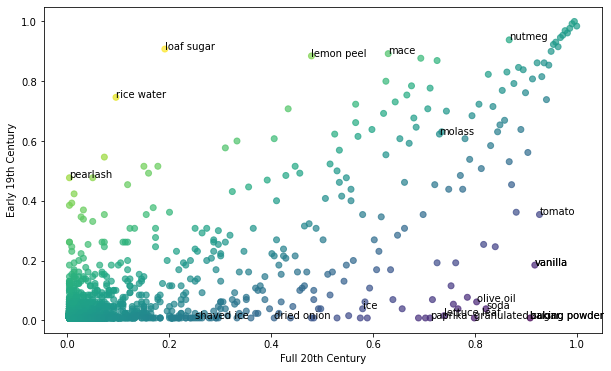

In [7]:
labels_early_19 = ['18th century' if 1800 <= year <= 1850 else 'Unused' for year in ingredients_normalized.index]
labels_20 = ['19th century' if  year < 1899 else 'Unused' for year in ingredients_normalized.index]

keyness, _ = chi2(ingredients_normalized.fillna(0), labels_early_19)
keyness_early_19 = pd.Series(keyness, index=ingredients_normalized.columns).sort_values(ascending=False)
keyness, _ = chi2(ingredients_normalized.fillna(0), labels_20)
keyness_20 = pd.Series(keyness, index=ingredients_normalized.columns).sort_values(ascending=False)

keyness_early_19.head(n=10)
keyness_20.head(n=10)

# Step 1: compute summed ingredient counts per year (in a matrix date x ingredients)
counts = df['ingredients'].str.split(';').groupby('date').sum().apply(pd.Series.value_counts).fillna(0)

# Step 2: construct two frequency rankings
early_nineteenth_century=counts[np.logical_and(counts.index>=1800, counts.index<=1850)].sum().rank(method='dense', pct=True)
full_twentieth_century=counts[counts.index>1899] .sum().rank(method='dense', pct=True)

# Step 3: merge the 19th and 20th century dataframes resulting into two dataframes
rankings=pd.DataFrame({'19th Century': nineteenth_century, '20th Century': twentieth_century})

# Step 4: produce the plot
fig = plt.figure(figsize=(10, 6))
plt.xlabel("Full 20th Century")
plt.ylabel("Early 19th Century")
plt.scatter(rankings['20th Century'], rankings['19th Century'],
            c=rankings['19th Century']-rankings['20th Century'],
            alpha=0.7) # c = color

# Add annotations of the 10 most distinctive ingredients
for i, row in rankings.loc[keyness_early_19.head(10).index].iterrows():
    plt.annotate(i, xy=(row['20th Century'], row['19th Century']))
for i, row in rankings.loc[keyness_20.head(10).index].iterrows():
    plt.annotate(i, xy=(row['20th Century'], row['19th Century']))
plt.show()

grouped = df.groupby(level='date')


We can see that loaf sugar, rice water and pearlash are among the distinct and frequent ingredients in the early 19th century.

For the 20th century tomato, vanilla are among the most frequent and most distinct ones.


With head we can look at some of the highest rated with head():

In [8]:
rankings.head()

,19th Century,20th Century
butter,0.992308,0.990868
salt,0.984615,1.000000
water,1.000000,0.995434
flour,0.969231,0.977169
nutmeg,0.938462,0.867580


Thus we can see that water is the most prevalent ingredient in the 19th century, along with butter.
In the 20th century this is salt, along with water. This may be as the price of salt declined in the 20th century.

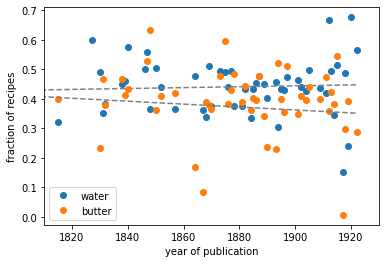

In [9]:
plot_trend('water', ingredients_normalized)
plot_trend('butter', ingredients_normalized)
plt.legend()
plt.show()

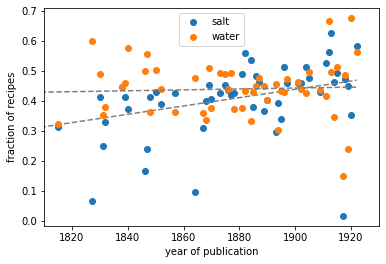

In [10]:
plot_trend('salt', ingredients_normalized)
plot_trend('water', ingredients_normalized)
plt.legend()
plt.show()